In [1]:
# load model

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


model_alpha = keras.models.load_model('models/predict_alpha.hdf5')
model_k = keras.models.load_model('models/predict_k.hdf5')


with open('ANDI_DATA/test_alpha.pkl', 'rb') as f:
    test_alpha = pickle.load(f) 
    
with open('ANDI_DATA/test_k.pkl', 'rb') as f:
    test_k = pickle.load(f) 

In [2]:
cases = ['single','multi', 'immobile', 'dimerization','confinement']

In [3]:
pred_test = {}

pred_test_alpha = {}
pred_test_k = {}


for case in cases:
    print('{} starting..'.format(case))
    pred_test_alpha[case] = model_alpha.predict(test_alpha['input'][case])
    pred_test_k[case] = model_k.predict(test_k['input'][case])

pred_test = {}
pred_test['alpha'] = pred_test_alpha
pred_test['k'] = pred_test_k

single starting..
multi starting..
immobile starting..
dimerization starting..
confinement starting..


In [4]:
# test_loss
import tensorflow.keras as keras



loss_test = {}

loss_test_alpha = {}

loss_test_k = {}



for case in cases:

    loss_test_alpha[case] = np.mean(keras.losses.mean_absolute_error(test_alpha['alpha'][case], pred_test['alpha'][case]))
    loss_test_k[case] = np.mean(keras.losses.mean_absolute_error(test_k['k'][case], pred_test['k'][case]))

loss_test['alpha'] = loss_test_alpha
loss_test['k'] = loss_test_k


print('---------------------------')
print('---------------------------')
print('---------------------------')
for case in cases:
    print('{} alpha_loss = {}'.format(('test', case), loss_test['alpha'][case]))
    print('{} k_loss = {}'.format(('test', case), loss_test['k'][case]))
    print('---------------------------')

---------------------------
---------------------------
---------------------------
('test', 'single') alpha_loss = 0.03786098584532738
('test', 'single') k_loss = 0.11579034477472305
---------------------------
('test', 'multi') alpha_loss = 0.08885423094034195
('test', 'multi') k_loss = 0.17171931266784668
---------------------------
('test', 'immobile') alpha_loss = 0.05974382162094116
('test', 'immobile') k_loss = 0.06496475636959076
---------------------------
('test', 'dimerization') alpha_loss = 0.08858588337898254
('test', 'dimerization') k_loss = 0.09779586642980576
---------------------------
('test', 'confinement') alpha_loss = 0.03191106393933296
('test', 'confinement') k_loss = 0.04783548787236214
---------------------------


In [5]:
# Find the length of trajectory.

def length_find(data):
    T = []
    for t, data_value in enumerate(data.reshape(191)):
        if data_value == 0:
            T.append(t)
            
    if len(T) >= 1:
        length = T[0]
        
    else:
        length = 191
        
    return length

In [6]:
length_test = {}


    
    
    
for case in cases:
    print('{} starting..'.format(('test', case)))
    length_test_case = []
    
    for n in range(len(test_k['input'][case])):
        length_test_case.append(length_find(test_k['input'][case][n].numpy()) + 9)
    length_test[case] = length_test_case

('test', 'single') starting..
('test', 'multi') starting..
('test', 'immobile') starting..
('test', 'dimerization') starting..
('test', 'confinement') starting..


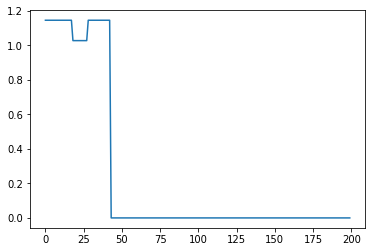

In [7]:
n = 4779
plt.plot(test_alpha['alpha']['multi'][n])

In [8]:
def cp_find(data,T):
    
    cp = []
    diff_data = np.abs(np.diff(data))
    
    for t in range(len(diff_data)):
        if diff_data[t] != 0:
            cp.append(t+1)
            
    if T not in cp:
        cp.append(T)
        
    return cp
    

In [9]:
# Find the Change points of trajectory.

cp_test = {}

for case in cases:
    print('{} starting..'.format(('test', case)))
    cp_case = []
    for n in range(len(test_alpha['alpha'][case])):
    
        cp_case.append(cp_find(test_alpha['alpha'][case][n], length_test[case][n]))
    cp_test[case] = cp_case

('test', 'single') starting..
('test', 'multi') starting..
('test', 'immobile') starting..
('test', 'dimerization') starting..
('test', 'confinement') starting..


In [10]:
def remove_close_elements(input_list):
    i = 0
    while i < len(input_list) - 1:
        if input_list[i+1] - input_list[i] < 3:
            input_list.pop(i+1)
        else:
            i += 1
    return input_list

In [11]:
predicted_cp = {}
for case in cases:
    predicted_cp[case] = []

print(predicted_cp)

{'single': [], 'multi': [], 'immobile': [], 'dimerization': [], 'confinement': []}


In [12]:
def jsc_method(pred_data, real_data):
    TP = 0
    FP = 0
    FN = 0

    dis_score = []

    for n in range(len(pred_data)):
    
        pred_cp = pred_data[n]
        real_cp = real_data[n]

#       TP, FP
        for cp_pred in pred_cp:
            TP_n = 0
            for cp_real in real_cp:
                if np.abs(cp_pred - cp_real) < 10:
                    TP += 1
                    TP_n += 1
                    dis_score.append(np.abs(cp_pred - cp_real))
            if TP_n == 0:
                FP += 1
                
               
        
#       FN
        for cp_real in real_cp:
            TP_n = 0
            for cp_pred in pred_cp:
                if np.abs(cp_pred - cp_real) < 10:
                    TP_n += 1
            if TP_n == 0:
                FN += 1
  

    JSC = TP/(TP + FP +FN)
    return JSC,TP,FP,FN,np.mean(dis_score)

In [13]:
# consider alpha and k

def cpd_v1_two_side(alpha,k,T,Th_alpha,Th_k, end_index):
    
    pred_cp = []
    reconstructed_feature1 = alpha[:int(T-end_index)]
    reconstructed_feature2 = k[:int(T-end_index)]
    T_length = T

    alpha_diff_max = np.max(np.abs(np.diff(reconstructed_feature1)))
    k_diff_max = np.max(np.abs(np.diff(reconstructed_feature2)))

    if alpha_diff_max > Th_alpha or k_diff_max > Th_k:
        if alpha_diff_max > k_diff_max:
            delta_feature = np.abs(np.diff(alpha))
            anomaly_index = 0
            anomaly_zip = []
            for n_zip in range(67):
                anomaly_zip.append([])


            for t, data_t in enumerate(delta_feature[:-1]):
                if data_t > Th_alpha:
                    anomaly_zip[anomaly_index].append((t,data_t))
                    if delta_feature[t + 1] <= Th_alpha:
                        anomaly_value = []
                        for a_index in range(len(anomaly_zip[anomaly_index])):
                            anomaly_value.append(anomaly_zip[anomaly_index][a_index][1])

                        max_anomaly_index = np.argmax(anomaly_value)
                        if (anomaly_zip[anomaly_index][max_anomaly_index][0] + 1) <= T:
                            pred_cp.append(anomaly_zip[anomaly_index][max_anomaly_index][0] + 1)

                        anomaly_index += 1
                        
        elif alpha_diff_max < k_diff_max:
            delta_feature = np.abs(np.diff(k))
            anomaly_index = 0
            anomaly_zip = []
            for n_zip in range(67):
                anomaly_zip.append([])


            for t, data_t in enumerate(delta_feature[:-1]):
                if data_t > Th_k:
                    anomaly_zip[anomaly_index].append((t,data_t))
                    if delta_feature[t + 1] <= Th_k:
                        anomaly_value = []
                        for a_index in range(len(anomaly_zip[anomaly_index])):
                            anomaly_value.append(anomaly_zip[anomaly_index][a_index][1])

                        max_anomaly_index = np.argmax(anomaly_value)
                        
                        if (anomaly_zip[anomaly_index][max_anomaly_index][0] + 1) <= T:
                            pred_cp.append(anomaly_zip[anomaly_index][max_anomaly_index][0] + 1)
                        anomaly_index += 1

        pred_cp.append(T)

    elif alpha_diff_max <= Th_alpha and k_diff_max <= Th_k:
        pred_cp.append(T)

    
    

    pred_cp = remove_close_elements(pred_cp)
    return pred_cp

In [14]:
# consider alpha

def cpd_v1_alpha_one_side(alpha,k,T,Th, end_index):

    pred_cp = []
    reconstructed_feature1 = alpha[:int(T-end_index)]
    reconstructed_feature2 = k[:int(T-end_index)]
    
    T_length = T

    alpha_diff_max = np.max(np.abs(np.diff(reconstructed_feature1)))
    k_diff_max = np.max(np.abs(np.diff(reconstructed_feature2)))

    if alpha_diff_max > Th:
        
        delta_feature = np.abs(np.diff(alpha))
        anomaly_index = 0
        anomaly_zip = []
        for n_zip in range(67):
            anomaly_zip.append([])


        for t, data_t in enumerate(delta_feature[:-1]):
            if data_t > Th:
                anomaly_zip[anomaly_index].append((t,data_t))
                if delta_feature[t + 1] <= Th:
                    anomaly_value = []
                    for a_index in range(len(anomaly_zip[anomaly_index])):
                        anomaly_value.append(anomaly_zip[anomaly_index][a_index][1])

                    max_anomaly_index = np.argmax(anomaly_value)
                    if (anomaly_zip[anomaly_index][max_anomaly_index][0] + 1) <= T:
                            pred_cp.append(anomaly_zip[anomaly_index][max_anomaly_index][0] + 1)

                    anomaly_index += 1


        pred_cp.append(T)

    elif alpha_diff_max <= Th:
        pred_cp.append(T)

    

    
    pred_cp = remove_close_elements(pred_cp)
    return pred_cp

In [15]:
# consider k

def cpd_v1_k_one_side(alpha,k,T,Th, end_index):

    pred_cp = []
    reconstructed_feature1 = alpha[:int(T-end_index)]
    reconstructed_feature2 = k[:int(T-end_index)]
    
    T_length = T

    alpha_diff_max = np.max(np.abs(np.diff(reconstructed_feature1)))
    k_diff_max = np.max(np.abs(np.diff(reconstructed_feature2)))

    if k_diff_max > Th:
        
        delta_feature = np.abs(np.diff(k))
        anomaly_index = 0
        anomaly_zip = []
        for n_zip in range(67):
            anomaly_zip.append([])


        for t, data_t in enumerate(delta_feature[:-1]):
            if data_t > Th:
                anomaly_zip[anomaly_index].append((t,data_t))
                if delta_feature[t + 1] <= Th:
                    anomaly_value = []
                    for a_index in range(len(anomaly_zip[anomaly_index])):
                        anomaly_value.append(anomaly_zip[anomaly_index][a_index][1])

                    max_anomaly_index = np.argmax(anomaly_value)
                    if (anomaly_zip[anomaly_index][max_anomaly_index][0] + 1) <= T:
                            pred_cp.append(anomaly_zip[anomaly_index][max_anomaly_index][0] + 1)

                    anomaly_index += 1


        pred_cp.append(T)

    elif alpha_diff_max <= Th:
        pred_cp.append(T)

    
    
    pred_cp = remove_close_elements(pred_cp)
    return pred_cp

real_cp = [27, 58, 72, 137]
predicted_cp = [28, 31, 59, 72, 137]
jsc_score = 1.0
TP_num = 5
FP_num = 0
FN_num = 0
loss of change point = 1.2


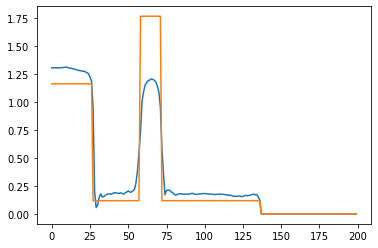

In [16]:
# example cpd_two side

dynamic_feature1 = 'alpha'
dynamic_feature2 = 'k'


case = 'multi'
n = 40

Th_alpha = 0.06
Th_k = 0.06

pred_cp = []


predicted_alpha = pred_test[dynamic_feature1][case][n]
predicted_k = pred_test[dynamic_feature2][case][n]

T_length = length_test[case][n]


pred_cp = cpd_v1_two_side(predicted_alpha,predicted_k,T_length,Th_alpha,Th_k,3)


plt.plot(predicted_k)
plt.plot(test_k[dynamic_feature2][case][n])


print('real_cp = {}'.format(cp_test[case][n]))
print('predicted_cp = {}'.format(pred_cp))
print('jsc_score = {}'.format(jsc_method([pred_cp],[cp_test[case][n]])[0]))
print('TP_num = {}'.format(jsc_method([pred_cp],[cp_test[case][n]])[1]))
print('FP_num = {}'.format(jsc_method([pred_cp],[cp_test[case][n]])[2]))
print('FN_num = {}'.format(jsc_method([pred_cp],[cp_test[case][n]])[3]))
print('loss of change point = {}'.format(jsc_method([pred_cp],[cp_test[case][n]])[4]))

In [17]:
ths = []
for i in range(5,11):
    ths.append(i*0.01)
    
ths

[0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

In [18]:
# JSC score

jsc_th_both = {}
loss_cp_th_both = {}
models = ['both']
for model_num, cp_detect_method in enumerate([cpd_v1_two_side]):
    dynamic_feature1 = 'alpha'
    dynamic_feature2 = 'k'

    end_index = 3

    jsc_th = {}
    loss_cp_th = {}
    for Th_alpha in ths:
        for Th_k in ths:
            Th_alpha = np.round(Th_alpha,2)
            Th_k = np.round(Th_k,2)
            print('Th_alpha = {}, Th_k = {} starting..'.format(Th_alpha,Th_k))
            predicted_cp = {}
            for case in cases:
                predicted_cp[case] = []
            for case in cases:
            #     for n in range(len(X_test_cp[case])):
                print('{} starting..'.format(case))

                N = len(length_test[case])
                for n in range(N):
                    T_length = length_test[case][n]



                    alpha = pred_test[dynamic_feature1][case][n]
                    k = pred_test[dynamic_feature2][case][n]

                    pred_cp = cp_detect_method(alpha,k,T_length,Th_alpha,Th_k, end_index)


                    predicted_cp[case].append(pred_cp)


#                 if n % 1400 == 0:
#                     print('progress_bar = {}'.format(n/N))


            anomaly_score = 0
            anomaly_case = []
            for case in cases:
                for n in range(N):
                    if len(predicted_cp[case][n]) > 2:
                        if np.min(np.diff(predicted_cp[case][n])) < 3:
                            anomaly_score +=1 
                            anomaly_case.append((case,n))

            if anomaly_score != 0:
                print('anomalous_case! ')

            else:
                print('Clear!')

            jsc_score = {}
            loss_cp = {}
            for case in cases:
                jsc_score[case] = (jsc_method(predicted_cp[case], cp_test[case])[0])
                loss_cp[case] = (jsc_method(predicted_cp[case], cp_test[case])[4])

            jsc_case = []
            loss_cp_case = []
            for case in cases:
                jsc_case.append(jsc_score[case])
                loss_cp_case.append(loss_cp[case])

            print('thresh_hold_alpha = {}, thresh_hold_k = {}, jsc = {}, loss_cp = {}'.format(Th_alpha,Th_k,np.mean(jsc_case), np.mean(loss_cp_case)))
            jsc_th = jsc_score
            loss_cp_th = loss_cp
            jsc_th_both[(Th_alpha,Th_k)] = jsc_th
            loss_cp_th_both[(Th_alpha,Th_k)] = loss_cp_th
            print(jsc_th_both[(Th_alpha,Th_k)])
            print(loss_cp_th_both[(Th_alpha,Th_k)])

Th_alpha = 0.05, Th_k = 0.05 starting..
single starting..
multi starting..
immobile starting..
dimerization starting..
confinement starting..
Clear!
thresh_hold_alpha = 0.05, thresh_hold_k = 0.05, jsc = 0.8132604426304443, loss_cp = 2.0164511522029107
{'single': 0.8824589295177531, 'multi': 0.7264376996805112, 'immobile': 0.8713109704877638, 'dimerization': 0.8203287275354466, 'confinement': 0.7657658859307475}
{'single': 0.22814076387220755, 'multi': 2.6249669130372815, 'immobile': 2.6370332283565783, 'dimerization': 2.3209298911946568, 'confinement': 2.2711849645538313}
Th_alpha = 0.05, Th_k = 0.06 starting..
single starting..
multi starting..
immobile starting..
dimerization starting..
confinement starting..
Clear!
thresh_hold_alpha = 0.05, thresh_hold_k = 0.06, jsc = 0.8143977152698627, loss_cp = 1.9741698861932178
{'single': 0.8897031090037179, 'multi': 0.7288081580624601, 'immobile': 0.8708791824477264, 'dimerization': 0.8213040552939017, 'confinement': 0.7612940715415073}
{'sing

Clear!
thresh_hold_alpha = 0.07, thresh_hold_k = 0.07, jsc = 0.8149838913657044, loss_cp = 1.876704444959574
{'single': 0.9104843654199878, 'multi': 0.72500119592429, 'immobile': 0.8710280163438052, 'dimerization': 0.8228241207638989, 'confinement': 0.7455817583765401}
{'single': 0.12812978267523722, 'multi': 2.4129368553016475, 'immobile': 2.6189860822144397, 'dimerization': 2.1363008501780123, 'confinement': 2.087168654428534}
Th_alpha = 0.07, Th_k = 0.08 starting..
single starting..
multi starting..
immobile starting..
dimerization starting..
confinement starting..
Clear!
thresh_hold_alpha = 0.07, thresh_hold_k = 0.08, jsc = 0.8143602129791816, loss_cp = 1.853513317697296
{'single': 0.914699119510964, 'multi': 0.724617299516674, 'immobile': 0.8706065248738284, 'dimerization': 0.8212600969305331, 'confinement': 0.7406180240639083}
{'single': 0.11870018393623544, 'multi': 2.3711602382492694, 'immobile': 2.6150332548329493, 'dimerization': 2.104551892359745, 'confinement': 2.0581210191

multi starting..
immobile starting..
dimerization starting..
confinement starting..
Clear!
thresh_hold_alpha = 0.09, thresh_hold_k = 0.1, jsc = 0.8101793883807857, loss_cp = 1.7627989355479854
{'single': 0.9323827046918123, 'multi': 0.7146216042491289, 'immobile': 0.8691166477916195, 'dimerization': 0.8141561653515487, 'confinement': 0.7206198198198198}
{'single': 0.08577947705969413, 'multi': 2.213103889033541, 'immobile': 2.598738647173032, 'dimerization': 1.9620590605691142, 'confinement': 1.9543136039045466}
Th_alpha = 0.1, Th_k = 0.05 starting..
single starting..
multi starting..
immobile starting..
dimerization starting..
confinement starting..
Clear!
thresh_hold_alpha = 0.1, thresh_hold_k = 0.05, jsc = 0.81163245457527, loss_cp = 1.8941862650064287
{'single': 0.9103776192845691, 'multi': 0.7155471212810338, 'immobile': 0.8716352833534774, 'dimerization': 0.819877474232606, 'confinement': 0.7407247747246635}
{'single': 0.16512814283979108, 'multi': 2.450815360336665, 'immobile': 

In [19]:
# We chose the threshold 0.06 in both cases.